# Questions duplicates EDA

### **🎯 Постановка задачі**
Метою даного проєкту є побудова моделі машинного навчання для визначення, чи є дві текстові питання дублікатами.

Задача формалізується як бінарна класифікація, де:

1 — питання є дублікатами (мають однаковий зміст),

0 — питання не є дублікатами.

Модель повинна на основі текстів двох питань передбачити ймовірність того, що вони є семантично еквівалентними.

### **📊 Метрика оцінювання**

Для оцінки якості моделей використовується Cross-Entropy Loss (Log Loss).

Ця метрика обрана з таких причин:

вона оцінює якість прогнозованих імовірностей, а не лише фінальне рішення;

є стандартною метрикою для задач бінарної класифікації;

сильно штрафує впевнені, але неправильні передбачення, що особливо важливо для даної задачі.

Математично Log Loss визначається як:

$$
\text{Log Loss} = -\frac{1}{N} \sum_{i=1}^{N}
\left[ y_i \log(p_i) + (1 - y_i) \log(1 - p_i) \right]
$$

де:

𝑦𝑖 ​— реальна мітка класу,

𝑝𝑖 — передбачена ймовірність класу 1.

Чим менше значення Log Loss, тим краща якість моделі.

### **🧾 Опис даних**

У проєкті використовується датасет, що складається з пар текстових питань та цільової змінної.

Кожен запис містить:

- question1 — перше питання;

- question2 — друге питання;

- is_duplicate — бінарна цільова змінна, що вказує, чи є питання дублікатами.

Дані містять тексти природною мовою, що потребує попередньої обробки, зокрема:

токенізації,
лематизації,
векторизації текстів.

In [2]:
pip install rapidfuzz

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 34.9 MB/s eta 0:00:00


In [9]:
import pandas as pd
import Functions as fy
import matplotlib.pyplot as plt
import seaborn as sns

In [13]:
train_fname = 'quora_question_pairs_train.csv.zip'
df = pd.read_csv(train_fname)
df = df.dropna()
df_test = pd.read_csv('quora_question_pairs_test.csv.zip')
df_test = df_test.dropna()

In [8]:
display(df.head(5)), df.info()

,id,qid1,qid2,question1,question2,is_duplicate
0,332278,459256,459257,The Iliad and the Odyssey in the Greek culture?,How do I prove that the pairs of three indepen...,0
1,196656,297402,297403,What is practical management and what is strat...,What are the practical aspects of strategic ma...,0
2,113125,184949,184950,How useful is MakeUseOf Answers?,Is there any Q&A site that is not Yahoo answer...,0
3,266232,101283,163744,Which is the best place to reside in India and...,Which ia the best place to visit in India?,0
4,122738,17811,27517,Why do so many people ask questions on Quora t...,Why don't many people posting questions on Quo...,1


<class 'pandas.core.frame.DataFrame'>
Index: 323429 entries, 0 to 323431
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            323429 non-null  int64 
 1   qid1          323429 non-null  int64 
 2   qid2          323429 non-null  int64 
 3   question1     323429 non-null  object
 4   question2     323429 non-null  object
 5   is_duplicate  323429 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 17.3+ MB


(None, None)

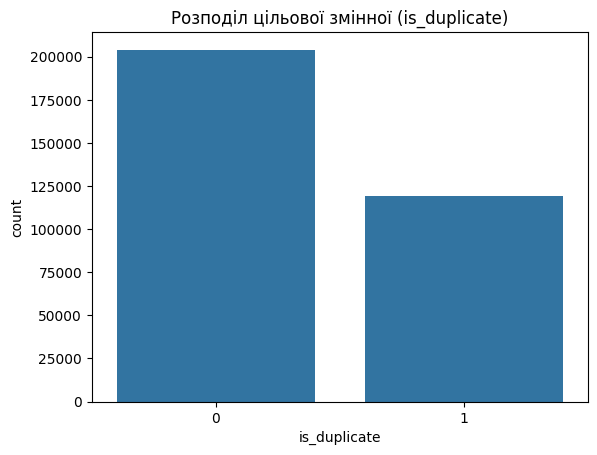

In [34]:
sns.countplot(x="is_duplicate", data=df)
plt.title("Розподіл цільової змінної (is_duplicate)")
plt.show()

In [12]:
df.isnull().sum()

,0
id,0
qid1,0
qid2,0
question1,1
question2,2
is_duplicate,0


Майже немає пропущених значеннь, тому ми просто видаляєм декілька рядків де є пропущені значення

In [18]:
df, vectorizer, tfidf_q1, tfidf_q2 = fy.tfidf_features(df)

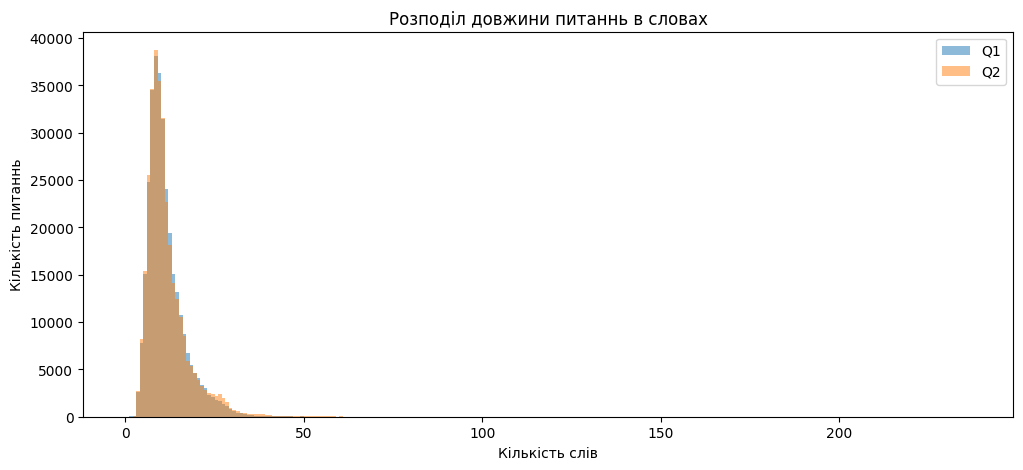

,len_q1_words,len_q2_words
count,323429.000000,323429.000000
mean,10.941715,11.184554
std,5.426282,6.312174
min,1.000000,1.000000
25%,7.000000,7.000000
50%,10.000000,10.000000
75%,13.000000,13.000000
max,125.000000,237.000000


In [6]:
#довжина в словах
df['len_q1_words'] = df['question1'].apply(lambda x: len(str(x).split()))
df['len_q2_words'] = df['question2'].apply(lambda x: len(str(x).split()))

plt.figure(figsize=(12,5))
bins = range(0, max(df['len_q1_words'].max(), df['len_q2_words'].max()) + 1)

plt.hist(df['len_q1_words'], bins=bins, alpha=0.5, label='Q1')
plt.hist(df['len_q2_words'], bins=bins, alpha=0.5, label='Q2')
plt.legend()
plt.title('Розподіл довжини питаннь в словах')
plt.xlabel('Кількість слів')
plt.ylabel('Кількість питаннь')
plt.show()

df[['len_q1_words', 'len_q2_words']].describe()

Обидва питання в датасеті мають схожий розподіл даних по довжині, також є питання викиди по довжині.

### **Розглянемо найбільш поширені слова:**



In [15]:
from collections import Counter
import re
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

stop = set(stopwords.words('english'))

def clean_and_split(text):
    text = str(text).lower()
    text = re.sub(r'[^a-z0-9\s]', '', text)
    words = text.split()
    words = [w for w in words if w not in stop and len(w) > 1]
    return words

df['q1_words'] = df['question1'].apply(clean_and_split)
df['q2_words'] = df['question2'].apply(clean_and_split)

all_q1_words = [word for words in df['q1_words'] for word in words]
all_q2_words = [word for words in df['q2_words'] for word in words]


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [16]:
top_q1 = pd.DataFrame(Counter(all_q1_words).most_common(20), columns=['word', 'count'])
top_q2 = pd.DataFrame(Counter(all_q2_words).most_common(20), columns=['word', 'count'])

from IPython.display import display, HTML

display(HTML(f"""
<div style="display: flex; gap: 50px;">
    <div>{top_q1.to_html()}</div>
    <div>{top_q2.to_html()}</div>
</div>
"""))

,word,count
0,best,27301
1,get,15205
2,india,11146
3,people,10138
4,like,10084
5,good,9593
6,would,9143
7,one,7519
8,quora,7077
9,make,7009


In [19]:
!pip install wordcloud --quiet

In [20]:
from wordcloud import WordCloud
text_all = " ".join(df["q1_clean"].astype(str)) + " " + " ".join(df["q2_clean"].astype(str))

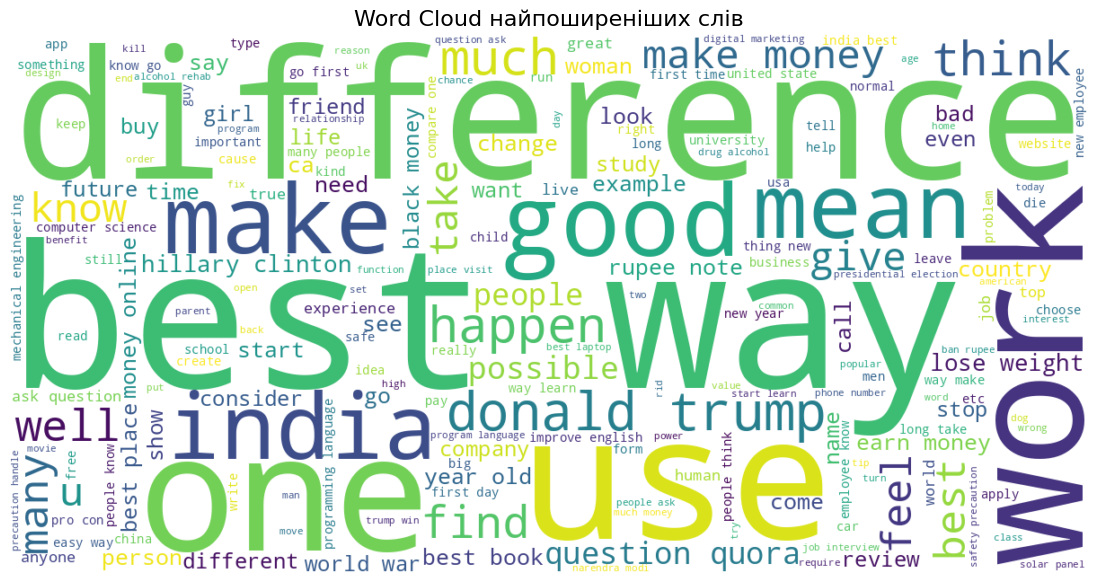

In [21]:
wordcloud = WordCloud(
    width=1200,
    height=600,
    background_color="white",
    max_words=200,
    colormap="viridis"
).generate(text_all)

plt.figure(figsize=(14, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Word Cloud найпоширеніших слів", fontsize=16)
plt.show()

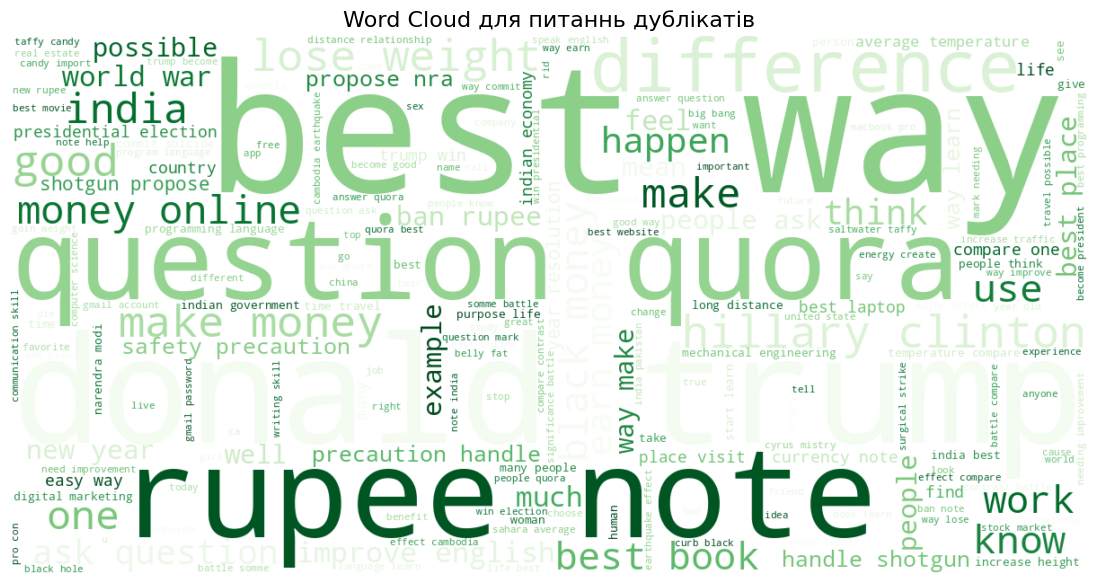

In [22]:
text_dup = " ".join(
    df[df["is_duplicate"] == 1]["q1_clean"].astype(str)
) + " " + " ".join(
    df[df["is_duplicate"] == 1]["q2_clean"].astype(str)
)

wc_dup = WordCloud(
    width=1200,
    height=600,
    background_color="white",
    max_words=200,
    colormap="Greens"
).generate(text_dup)

plt.figure(figsize=(14, 7))
plt.imshow(wc_dup, interpolation="bilinear")
plt.axis("off")
plt.title("Word Cloud для питаннь дублікатів", fontsize=16)
plt.show()

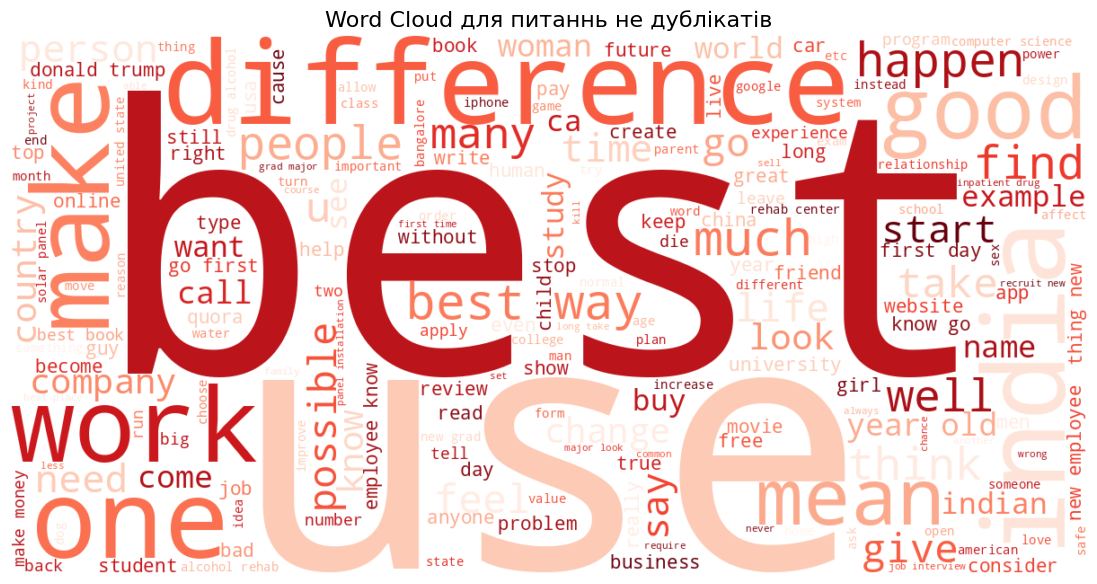

In [23]:
text_nondup = " ".join(
    df[df["is_duplicate"] == 0]["q1_clean"].astype(str)
) + " " + " ".join(
    df[df["is_duplicate"] == 0]["q2_clean"].astype(str)
)

wc_nondup = WordCloud(
    width=1200,
    height=600,
    background_color="white",
    max_words=200,
    colormap="Reds"
).generate(text_nondup)

plt.figure(figsize=(14, 7))
plt.imshow(wc_nondup, interpolation="bilinear")
plt.axis("off")
plt.title("Word Cloud для питаннь не дублікатів", fontsize=16)
plt.show()

Word clouds були згенеровані для візуалізації найчастіше вживаних слів у наборі даних.

Порівняння пар дублікатних та недублікатних запитань показує, що хоча багато спільних слів зустрічаються в обох класах, дублікатні запитання, як правило, мають більше тематично та семантично пов’язаних термінів.

Це додатково обґрунтовує використання ознак семантичної подібності, таких як TF-IDF та ембеддинги SBERT.

### **Аналіз залежностей цільової змінної від ознак тексту:**

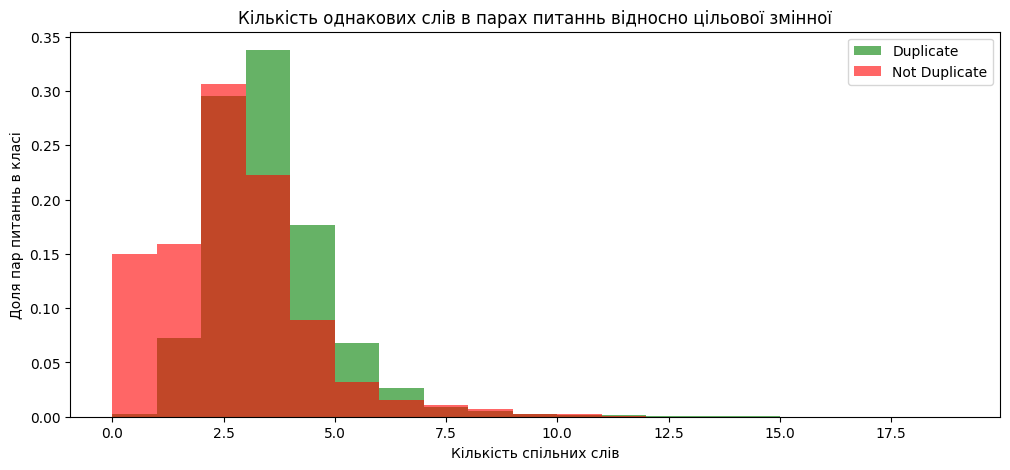

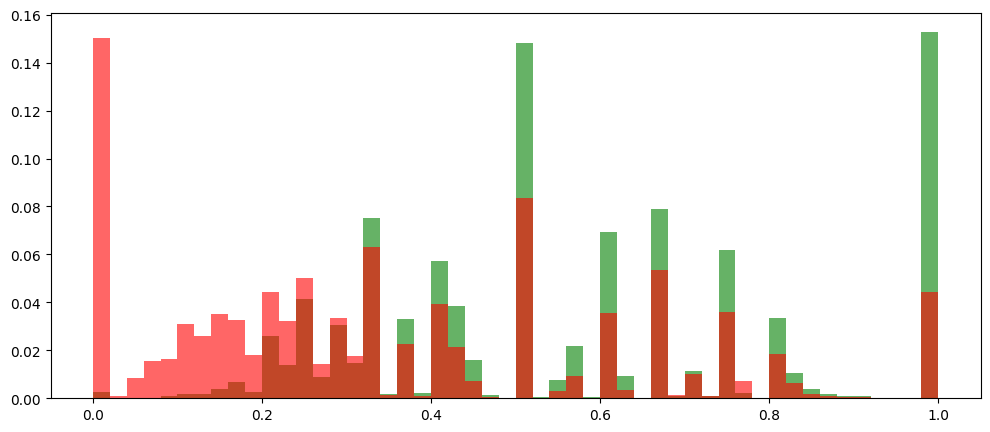

In [24]:
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
max_common = max(df['common_words'].max(), df['common_words'].max())
bins_common = np.arange(0, max_common + 2)

plt.figure(figsize=(12,5))

plt.hist(df[df['is_duplicate']==1]['common_words'], bins=bins_common, color='green', alpha=0.6,
         label='Duplicate', density=True)
plt.hist(df[df['is_duplicate']==0]['common_words'], bins=bins_common, color='red', alpha=0.6,
         label='Not Duplicate', density=True)

plt.title('Кількість однакових слів в парах питаннь відносно цільової змінної')
plt.xlabel('Кількість спільних слів')
plt.ylabel('Доля пар питаннь в класі')
plt.legend()
plt.show()

bins_jaccard = np.linspace(0, 1, 51)
weights_dup = np.ones(len(df[df['is_duplicate']==1])) / len(df[df['is_duplicate']==1])
weights_nodup = np.ones(len(df[df['is_duplicate']==0])) / len(df[df['is_duplicate']==0])

plt.figure(figsize=(12,5))
plt.hist(df[df['is_duplicate']==1]['jaccard'], bins=bins_jaccard, color='green', alpha=0.6,
         label='Duplicate', weights=weights_dup)
plt.hist(df[df['is_duplicate']==0]['jaccard'], bins=bins_jaccard, color='red', alpha=0.6,
         label='Not Duplicate', weights=weights_nodup)
plt.show()

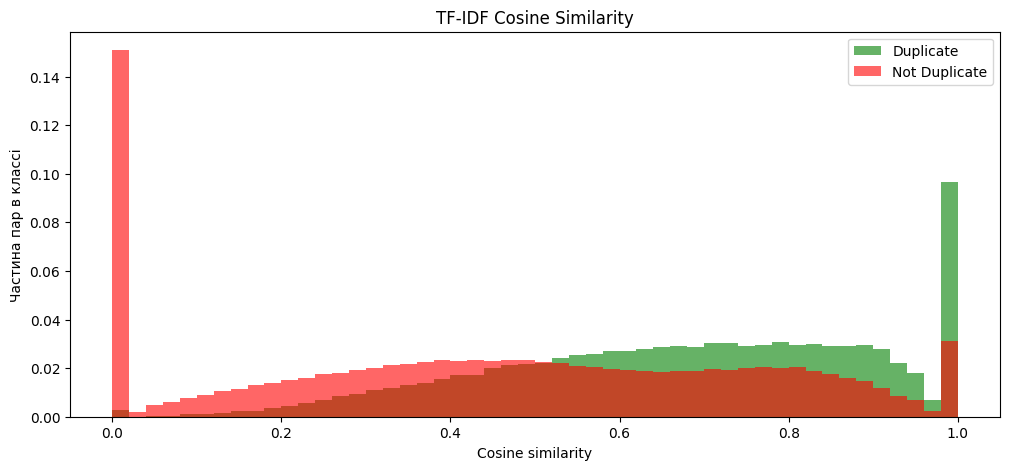

In [29]:
bins_cosine = np.linspace(0, 1, 51)

weights_dup = np.ones(len(df[df['is_duplicate']==1])) / len(df[df['is_duplicate']==1])
weights_nodup = np.ones(len(df[df['is_duplicate']==0])) / len(df[df['is_duplicate']==0])

plt.figure(figsize=(12,5))
plt.hist(df[df['is_duplicate']==1]['cosine_sim'], bins=bins_cosine, color='green', alpha=0.6,
         label='Duplicate', weights=weights_dup)
plt.hist(df[df['is_duplicate']==0]['cosine_sim'], bins=bins_cosine, color='red', alpha=0.6,
         label='Not Duplicate', weights=weights_nodup)

plt.title('TF-IDF Cosine Similarity')
plt.xlabel('Cosine similarity')

plt.ylabel('Частина пар в классі')
plt.legend()
plt.show()

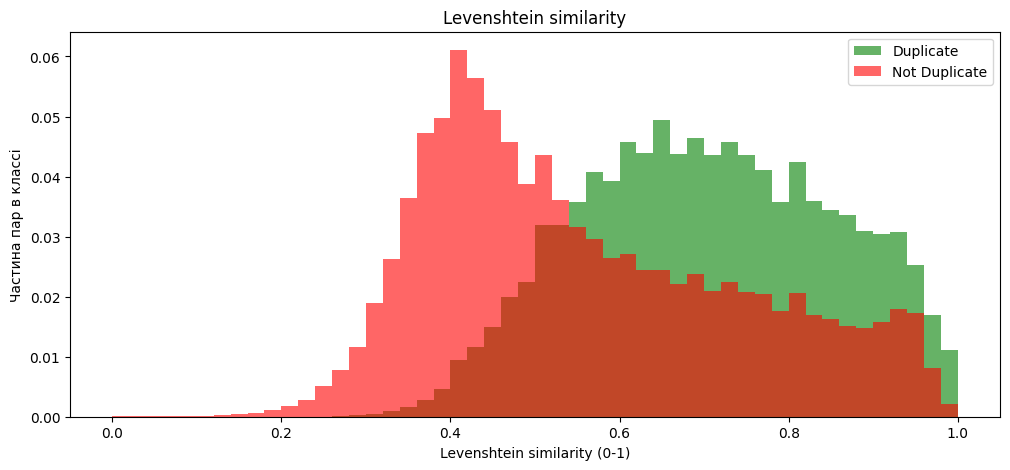

In [33]:
bins_lev = np.linspace(0, 1, 51)

weights_dup = np.ones(len(df[df['is_duplicate']==1])) / len(df[df['is_duplicate']==1])
weights_nodup = np.ones(len(df[df['is_duplicate']==0])) / len(df[df['is_duplicate']==0])

plt.figure(figsize=(12,5))
plt.hist(df[df['is_duplicate']==1]['lev_ratio'], bins=bins_lev, color='green', alpha=0.6,
         label='Duplicate', weights=weights_dup)
plt.hist(df[df['is_duplicate']==0]['lev_ratio'], bins=bins_lev, color='red', alpha=0.6,
         label='Not Duplicate', weights=weights_nodup)

plt.title('Levenshtein similarity')
plt.xlabel('Levenshtein similarity (0-1)')
plt.ylabel('Частина пар в классі')
plt.legend()
plt.show()

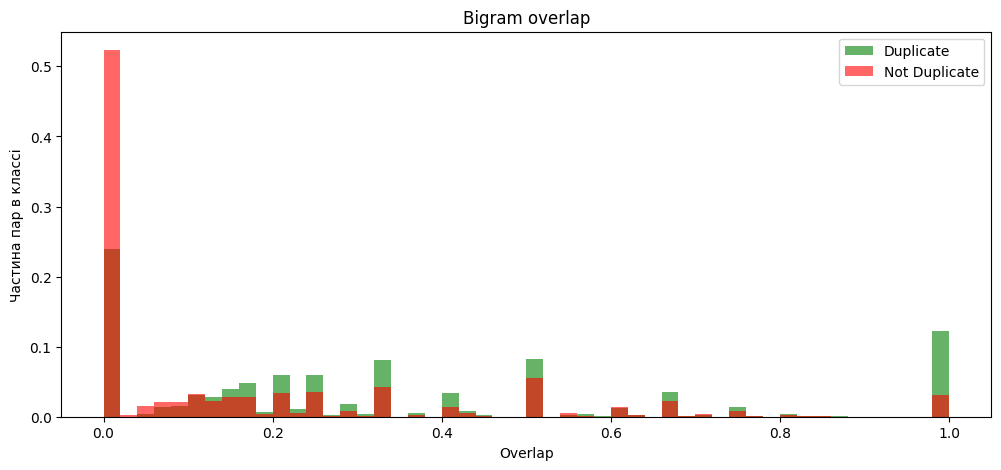

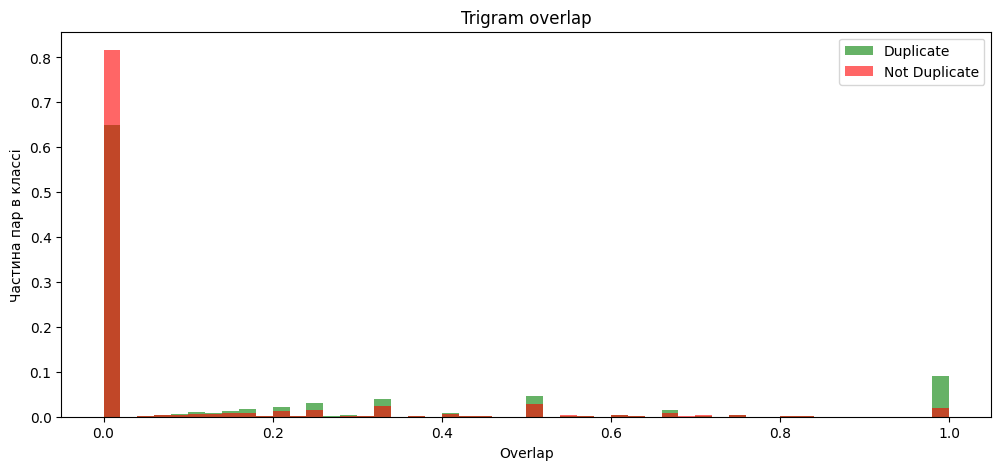

In [30]:
bins_ngram = np.linspace(0, 1, 51)

plt.figure(figsize=(12,5))
plt.hist(df[df['is_duplicate']==1]['bigram_overlap'], bins=bins_ngram, color='green', alpha=0.6,
         label='Duplicate', weights=weights_dup)
plt.hist(df[df['is_duplicate']==0]['bigram_overlap'], bins=bins_ngram, color='red', alpha=0.6,
         label='Not Duplicate', weights=weights_nodup)
plt.title('Bigram overlap')
plt.xlabel('Overlap')
plt.ylabel('Частина пар в классі')
plt.legend()
plt.show()

plt.figure(figsize=(12,5))
plt.hist(df[df['is_duplicate']==1]['trigram_overlap'], bins=bins_ngram, color='green', alpha=0.6,
         label='Duplicate', weights=weights_dup)
plt.hist(df[df['is_duplicate']==0]['trigram_overlap'], bins=bins_ngram, color='red', alpha=0.6,
         label='Not Duplicate', weights=weights_nodup)
plt.title('Trigram overlap')
plt.xlabel('Overlap')
plt.ylabel('Частина пар в классі')
plt.legend()
plt.show()

In [ ]:
df = pd.read_csv('final_features.csv.zip')

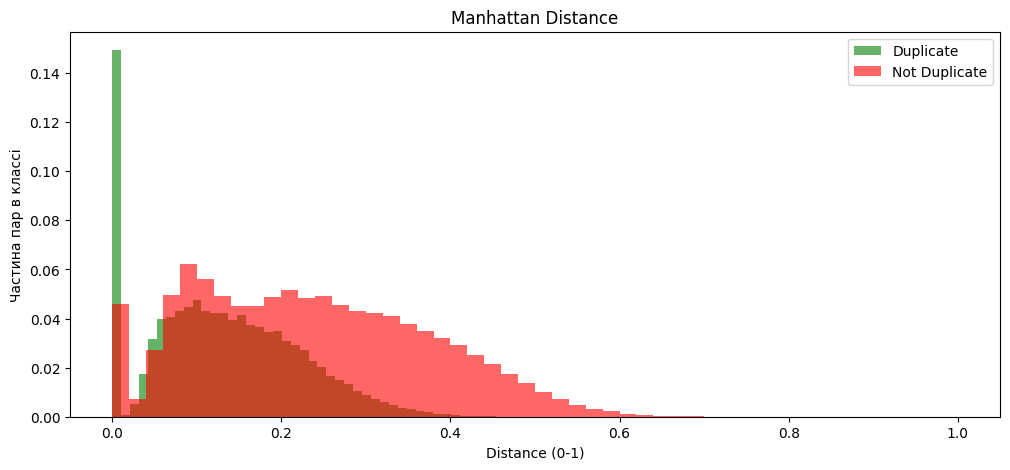

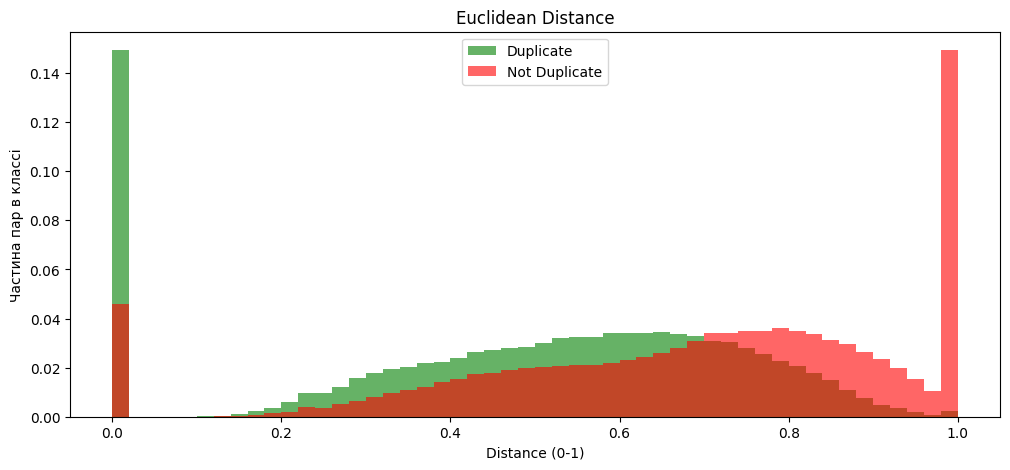

In [32]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
df[['manhattan_norm', 'euclidean_norm']] = scaler.fit_transform(df[['manhattan', 'euclidean']])

weights_dup = np.ones(len(df[df['is_duplicate']==1])) / len(df[df['is_duplicate']==1])
weights_nodup = np.ones(len(df[df['is_duplicate']==0])) / len(df[df['is_duplicate']==0])

plt.figure(figsize=(12,5))
plt.hist(df[df['is_duplicate']==1]['manhattan_norm'], bins=50, color='green', alpha=0.6,
         label='Duplicate', weights=weights_dup)
plt.hist(df[df['is_duplicate']==0]['manhattan_norm'], bins=50, color='red', alpha=0.6,
         label='Not Duplicate', weights=weights_nodup)
plt.title('Manhattan Distance')
plt.xlabel('Distance (0-1)')
plt.ylabel('Частина пар в классі')
plt.legend()
plt.show()

plt.figure(figsize=(12,5))
plt.hist(df[df['is_duplicate']==1]['euclidean_norm'], bins=50, color='green', alpha=0.6,
         label='Duplicate', weights=weights_dup)
plt.hist(df[df['is_duplicate']==0]['euclidean_norm'], bins=50, color='red', alpha=0.6,
         label='Not Duplicate', weights=weights_nodup)
plt.title('Euclidean Distance')
plt.xlabel('Distance (0-1)')
plt.ylabel('Частина пар в классі')
plt.legend()
plt.show()

На побудованих графіках видно, що інженерні ознаки, засновані на лексичній та семантичній подібності запитань, демонструють різну поведінку для класів дублікатних і недублікатних пар.

Графіки були нормалізовані, тому через різну кількість екземплярів в классі

Для дублікатних запитань характерні вищі значення показників спільності (кількість спільних слів, коефіцієнт Жаккара, cosine similarity), тоді як для недублікатних пар ці значення, як правило, нижчі. Водночас метрики відстані (евклідова та мангеттенська) мають протилежну тенденцію — менші значення для семантично близьких запитань.

Отримані результати свідчать про те, що побудовані ознаки містять корисну інформацію для розрізнення дублікатних та недублікатних запитань і можуть бути ефективно використані як в класичних моделях машинного навчання, так і в ансамблевих підходах разом із текстовими представленнями.

### 🧠 Висновок

Проведений дослідницький аналіз даних показав, що задача визначення дублікатів питань є складною через варіативність формулювань та багатозначність природної мови. Навіть питання з однаковим змістом можуть суттєво відрізнятися на рівні окремих слів і структури речень.

Аналіз розподілу цільової змінної підтвердив наявність дисбалансу між класами, що необхідно враховувати під час побудови моделей. Дослідження текстових характеристик та інженерних ознак (кількість спільних слів, коефіцієнт Жаккара, n-грамні перетини, символьні метрики) показало, що такі ознаки дійсно містять інформацію, корисну для розрізнення дублікатів і недублікатів, однак не завжди є достатніми для повного опису семантичної подібності.

Результати EDA свідчать про доцільність використання як лексичних підходів (наприклад, TF-IDF), так і більш глибоких семантичних представлень тексту (наприклад, ембеддінги). Це мотивує подальший перехід до побудови та порівняння різних моделей машинного навчання, а також комбінування ручних ознак із векторними представленнями тексту для досягнення кращої якості класифікації.